# Table of Contents
- [Context](#context)
  - [What will you learn](#what-you-will-learn)
  - [Prerequisites](#prerequisites)
  - [Introduction](#introduction)
  - [Approach Overview](#approach-overview) 
  - [Scope and Limitations](#scope-and-limitations)
- [Coding](#coding)
  - [Step 1: Setting up the environment](#step-1-setting-up-the-environment)
  - [Step 2: Loading the data](#step-2-loading-the-data)
  - [Step 3: Filtering Languages](#step-3-filtering-languages)
  - [Step 4: Data Preperation](#step-4-data-preperation)
    - [Step 4.1: Tokenization](#step-41-tokenization)
    - [Step 4.2: Bag-of-Words](#step-42-bag-of-words)
    - [Step 4.3: Encode Labels](#step-43-encode-labels)
  - [Step 5: Train the classifier](#step-5-train-the-classifier)
  - [Step 6: Evaluation](#step-6-evaluate)
- [Conclusion](#conclusion)
- [Sources](#sources)

# Context

## What You Will Learn
By the end of this tutorial, you will understand how to: 
- Prepare multilingual textual data for text classification 
- Build a shared vocabulary across languages 
- Represent text using a Bag-of-Words approach 
- Train and evaluate a linear multi-class classifier 
- Interpret predictions and confidence scores 
- Make sense of everything mentioned in this list

## Prerequisites
You will need the following to be able to follow the tutorial
- Estimated time: 30-60 minutes
- 2GB Free Storage 
- 4GB RAM
- Windows 10/11
- Visual Studio Code + Jupyter Extension
- Anaconda (For easy environment management)
- Basic python knowledge

## Introduction
In this tutorial, we will build a language classifier. A language classifier is a model that can predict which language a sentence is written in.

Language classification is one of the most basic problems in Natural Language Processing (NLP). Because of this, it is a great starting point if you are new to NLP or machine learning in general. The task is easy to understand, yet it introduces many of the core concepts used in more advanced NLP systems.

Language classification also has many practical applications in the real world. One example you interact with almost every day is search engines such as Google or Bing. When you type a query in a certain language, the search engine first detects that language and then returns results in the same language. Also many translation tools provide a "Detect Language" function where you can type and the tool figures out what language it is, think of tools like Google Translate and DeepL.

In the next sections, we will go step by step through the process of building a simple language classifier, starting from loading a dataset and ending with training and evaluating a model.

## Approach Overview

This tutorial is inspired by Deep Learning with Python (3rd Edition) by François Chollet, specifically chapter 14 text classification [[1]](#1-francois-chollet-deep-learning-with-python-third-edition-chapter-14-text-classification-httpsdeeplearningwithpythoniochapterschapter14_text-classification). In this chapter, different ways of working with text are introduced, such as models that look at word order (sequence-based models) versus models that only care about which words appear (set-based models).

In this tutorial, we deliberately keep things simple. We use a set-based approach with word-level tokenization, which means the model predicts the language of a sentence by looking only at which words are present in that sentence, not at their order.

## Scope and Limitations

To keep the problem well-defined and clear, we restrict the model to a small set of languages. The classifier will only predict one of the languages it was trained on.

It is important to note that:
- This model cannot detect unsupported languages.
- Predicted probabilities represent the model’s relative confidence among the supported languages, not an absolute measure of correctness.
- A high predicted probability does not guarantee that the input truly belongs to the predicted language.

These limitations are not flaws, but expected properties of simple set-based models.

# Coding

## Step 1: Setting up the environment

We will work using python environments. That means we will work inside of a python container which isn't being influenced by anything else on your pc. This way we can make sure that your code will run exactly the same way as mine.

First we need to create a python environment, which we will name `myenv_llm`, with the version `3.10.15`. This can be done by opening the `Command Prompt` and running the following command.

`conda create -n myenv_llm python=3.10.15`

Once the environment is created, you can select the newly created environment as interpreter in visual studio code. Do `CTRL + SHIFT + P` type `Python: Select Interpreter` and click on it. This should show a list of environments, try to find the newly created environment `myenv_llm`.

To test if it worked we can run the code cel below using `CTRL + ENTER`. This will prompt you to install the ipykernel package, proceed if so.

In [1]:
print("Hello World!")

Hello World!


To prepare the environment for the rest of the tutorial we need to install the following 4 packages:
- **pandas** [[2]](#2-pandas-developers-getting-started-pandas-233-documentation-httpspandaspydataorgpandas-docsversion233getting_startedindexhtml): to analyze and modify data
- **fsspec** [[3]](#3-fsspec-developers-fsspec-documentation-latest-httpsfilesystem-specreadthedocsioenlatest): to read dataset files, especially from remote / virtual filesystems
- **huggingface_hub** [[4]](#4-hugging-face-developers-huggingface_hub-documentation-latest-httpshuggingfacecodocshuggingface_hub): to download datasets from Hugging Face (A popular website for datasets)
- **scikit-learn** [[5]](#5-scikit-learn-developers-scikit-learn-172-documentation-httpsscikit-learnorg17): to encode labels
- **matplotlib** [[6]](#6-matplotlib-developers-matplotlib-3108-documentation-httpsmatplotliborg3108): to plot fancy demographics
- **seaborn** [[7]](#7-seaborn-developers-seaborn-documentation-httpsseabornpydataorg): to plot fancy demographics

These packages can be installed by running the following code cell

In [ ]:
!pip install pandas==2.3.3 fsspec==2025.12.0 huggingface_hub==1.2.3 scikit-learn==1.7.2 matplotlib==3.10.8 seaborn==0.13.2

We can check if the your python and package versions match the ones used in the tutorial by running the code below

In [3]:
import sys
import pandas as pd 
import fsspec
import huggingface_hub
import sklearn
import matplotlib
import seaborn as sns

print("Python version:", sys.version[:7], "(should be 3.10.15)")
print("pandas version:", pd.__version__, "(should be 2.3.3)")
print("fsspec version:", fsspec.__version__, "(should be 2025.12.0)")
print("huggingface_hub version:", huggingface_hub.__version__, "(should be 1.2.3)")
print("scikit-learn version:", sklearn.__version__, "(should be 1.7.2)")
print("matplotlib version:", matplotlib.__version__, "(should be 3.10.8)")
print("seaborn version:", sns.__version__, "(should be 0.13.2)")

Python version: 3.10.15 (should be 3.10.15)
pandas version: 2.3.3 (should be 2.3.3)
fsspec version: 2025.12.0 (should be 2025.12.0)
huggingface_hub version: 1.2.3 (should be 1.2.3)
scikit-learn version: 1.7.2 (should be 1.7.2)
matplotlib version: 3.10.8 (should be 3.10.8)
seaborn version: 0.13.2 (should be 0.13.2)


Now that we have the environment working inside visual studio code, we can start coding! 

## Step 2: Loading the data

As dataset we will use the *Language Identification dataset by Papluca* [[8]](#8-papluca-language-identification-dataset-hugging-face-httpshuggingfacecodatasetspaplucalanguage-identification). This dataset is an excellent dataset for a basic language classification exercise. This dataset consists of reviews posted on Amazon in a total of 20 languages.

Loading the dataset

In [4]:
import pandas as pd

df_train = pd.read_csv("hf://datasets/papluca/language-identification/train.csv")
df_validation = pd.read_csv("hf://datasets/papluca/language-identification/valid.csv")

df_train

c:\Users\thezo\anaconda3\envs\myenv_llm2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,labels,text
0,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,bg,размерът на хоризонталната мрежа може да бъде ...
2,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,ru,Он увеличил давление .
...,...,...
69995,ja,本格的なゲーミングヘッドホンでした。 今まで使ってた1万円するパナソニックのヘッドホンは何だ...
69996,el,"Ναι , ξέρω ένα που είναι ακόμα έτσι , αλλά αυτ..."
69997,ur,اور مجھے اس ملک کے بارے میں معلوم نہیں ہے کہ گ...
69998,es,Se me rompió uno al sacarlo del cargador. Cali...


This is a brief overview of what our dataset looks like. it contains a label and text per row, and has a total of 70000 rows.

Checking present languages

In [5]:
df_train['labels'].unique()

array(['pt', 'bg', 'zh', 'th', 'ru', 'pl', 'ur', 'sw', 'tr', 'es', 'ar',
       'it', 'hi', 'de', 'el', 'nl', 'fr', 'vi', 'en', 'ja'], dtype=object)

## Step 3: Filtering Languages

20 languages is a bit much for a simple tutorial. Therefore we will filter down the dataset to just 5 languages. We will filter on the following languages:
- English
- Spanish
- Italian
- Portuguese
- Russian

These languages are chosen for the following reasons: English to have an interpretable language. Spanish, Italian and Portguese since those 3 languages are closely related and share many words. And Russian so we have one language that uses a different alphabet and doesn't look anything like the other languages.



Filter the dataset on these 5 languages

In [6]:
target_languages = ["en", "es", "it", "pt", "ru"]

# filter the train and val set
df_train_filtered = df_train[df_train["labels"].isin(target_languages)].reset_index(drop=True)
df_validation_filtered = df_validation[df_validation["labels"].isin(target_languages)].reset_index(drop=True)

# sample of the filtered train set
df_train_filtered

,labels,text
0,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,ru,Он увеличил давление .
2,pt,Duas raças diferentes de cães castanhos e bran...
3,es,Un producto de una calidad y capacidad increíb...
4,it,Una donna sta affettando della carne.
...,...,...
17495,en,Color bleeds. Softness is lost after only one ...
17496,es,"Tuve que devolverlos, el auricular izquierdo s..."
17497,it,Il governo israeliano autorizza nuovi insediam...
17498,es,Muy bueno para gente con alergias


We can make sure it worked by printing the unique labels once more

In [7]:
df_train_filtered['labels'].unique()

array(['pt', 'ru', 'es', 'it', 'en'], dtype=object)

Perfect! We managed to exclude all the rows that contain languages we don't want in our dataset.

## Step 4: Data Preperation

Now that the dataset is filtered to just 5 languages, we can start preparing the data for machine learning! In our dataframe we have one columns for all the labels and one for all the reviews. We want to load both into variables separately.

Load in reviews

In [8]:
reviews_train = df_train_filtered["text"].tolist()
reviews_val   = df_validation_filtered["text"].tolist()

# sample reviews in train set
reviews_train[:10]

['os chefes de defesa da estónia, letónia, lituânia, alemanha, itália, espanha e eslováquia assinarão o acordo para fornecer pessoal e financiamento para o centro.',
 'Он увеличил давление .',
 'Duas raças diferentes de cães castanhos e brancos brincam na praia.',
 'Un producto de una calidad y capacidad increíbles que será el placer de todo amante de la tecnología',
 'Una donna sta affettando della carne.',
 'Эти инструменты приведены вместе в mantinada songs с рифм тахикардия текстов .',
 'não usa muito o botão de pesquisa, pois não?',
 'Jactos do exército matam 38 militantes em ataques aéreos no Noroeste do Paquistão',
 'El tacto es horrible, el dedo se engancha cuando deslizas',
 'Casco para decoración. No homologado y poco más que un casco de juguete, si tienes un accidente es mejor no llevar nada en la cabeza antes que llevar un casco como este. Al igual que las gafas que son de plástico inyectado y de pésima calidad. Solo hay una cosa que lo justifique, el precio.']

Load in labels

In [9]:
labels_train = df_train_filtered['labels'].tolist()
labels_val   = df_validation_filtered['labels'].tolist()

# sample labels in train set
labels_train[:10]

['pt', 'ru', 'pt', 'es', 'it', 'ru', 'pt', 'pt', 'es', 'es']

### Step 4.1: Tokenization


Traditionally in machine learning, you input data with a label so the model can learn the relations between the data and the label, after the model learned the relations between the data and the labels, you can input data without labels into the model, which then can predict an output. In our case, that translates to inputting the amazon reviews (our data) and the languages (our labels) the model, so it can learn the relations between them, and after the model learned the relations, we can enter an amazon review without a label (or any other sort of text data) and expect a predicted language as output. Sadly, it's not as simple as inputting textual data and labels into a model and receiving a language prediction as output. Models rely on numbers for both input and output. Therefore, we need to convert text into numbers so the model can process it. 

There are multiple ways to convert textual data into numeric data. In this tutorial we will use the simplest form of tokenization, *word-level tokenization* in combination with a *vocabulary* and a *bag-of-words* representation [[1]](#1-francois-chollet-deep-learning-with-python-third-edition-chapter-14-text-classification-httpsdeeplearningwithpythoniochapterschapter14_text-classification) (bag-of-words will be covered in #4.2). Each of these terms will be explained one by one, starting with Word-Level Tokenization.

#### Word-Level Tokenization
Word-level tokenization is the process of splitting a sentence into individual tokens (or in our case, words. since we are using word-level tokenization). 

For example, the sentence:

`the quick brown fox jumps over the lazy dog.`

can be tokenized into:

`['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']`


Notice that each word, as well as the punctuation, becomes a separate token.

#### Vocabulary and Encoding
Once we have tokens, we need to convert each token into a number for our model to understand. This is done using a vocabulary, which assigns a unique number to each token. 

For example, using the following vocabulary:

- 0 = `[UNKNOWN WORD]` (0 is always reserved for unknown words)
- 1 = `the`  
- 2 = `quick`  
- 3 = `brown`  
- 4 = `fox`  
- 5 = `jumps`  
- 6 = `over`  
- 7 = `lazy`  
- 8 = `dog`  
- 9 = `.`  

We can encode our previously tokenized sentence to the following encoding:

```py
Tokenized: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
Encoded:   [  1  ,   2    ,    3   ,   4  ,   5    ,   6   ,   1  ,   7   ,   8  ,  9 ]
```

The word `the` appears twice, so it's encoded as the number `1` in both cases. Now that we understand the theory, it's time for the implementation. We will start by building a vocabulary, since tokenizers depend on a vocabulary.

Define function to build vocabulary from textual data

In [10]:
import collections
import re

def build_word_vocabulary(texts, max_size):
    counter = collections.Counter()

    for text in texts:
        tokens = re.findall(r"[\w]+|[.,!?;]", text.lower())
        counter.update(tokens)

    vocabulary = ["[UNK]"]
    for token, _ in counter.most_common(max_size - 1):
        vocabulary.append(token)

    return {token: idx for idx, token in enumerate(vocabulary)}

Build vocabulary on example sentence mentioned earlier

In [11]:
text_example = ["the quick brown fox jumps over the lazy dog."]
vocabulary_example = build_word_vocabulary(text_example, max_size=10)

print("vocabulary (from example sentence):")
vocabulary_example

vocabulary (from example sentence):


{'[UNK]': 0,
 'the': 1,
 'quick': 2,
 'brown': 3,
 'fox': 4,
 'jumps': 5,
 'over': 6,
 'lazy': 7,
 'dog': 8,
 '.': 9}

The vocabulary is exactly similar to the example given earlier. Now that we built our vocabulary, we can use it in combination with the wordtokenizer to encode textual data into numeric data.

Define the WordTokenizer

In [12]:
class WordTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def __call__(self, text):
        text = text.lower()
        tokens = re.findall(r"[\w]+|[.,!?;]", text)
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

Create instance of the wordtokenizer with the example vocabulary

In [13]:
tokenizer = WordTokenizer(vocabulary_example)

We can use the tokenizer to encode textual data into numeric data

Example 1

In [14]:
tokenizer("the quick brown fox jumps over the lazy dog.")

[1, 2, 3, 4, 5, 6, 1, 7, 8, 9]

Example 2

In [15]:
tokenizer("the quick orange fox jumps over the lazy dog.")


[1, 2, 0, 4, 5, 6, 1, 7, 8, 9]

Note how in the second example, the tokenizer returns a 0. This is because the vocabulary has never seen the word `orange` and therefore falls back to 0. This will be more clear if we try to encode a sentence that is completely different.

Example 3

In [16]:
tokenizer("Obviously, I am having the time of my life following this tutorial!")

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

Great! We managed to fill a vocabulary with the sentence: `"the quick brown fox jumps over the lazy dog."` and use it to encode textual data into numeric data. However, building a vocabulary off of a single sentence isn't pratical, since it results in a very limited vocabulary. For most text classification problems, a vocabulary of 20 thousand words is a good starting point [[1]](#1-francois-chollet-deep-learning-with-python-third-edition-chapter-14-text-classification-httpsdeeplearningwithpythoniochapterschapter14_text-classification). We can achieve this by using our dataset to fill the vocabulary instead.

Earlier we splitted our train data into `reviews_train` and `label_train`. Now we can use the reviews inside `reviews_train` to fill a vocabulary. This vocabulary will contain a combination of unique words over 5 different languages. The top 20.000 most frequent words will make it inside the vocabulary. Other words in `reviews_train` that don't appear frequent enough are left out of the vocabulary.

> *Why not allow all the words of the training data in the vocabulary?*
>
> *A bigger vocabulary means longer processing time. In some scenario's this could be a good trade-off. However, if we start adding every single word to the vocabulary, even words that only appear once, it wouldn't improve model performance, only slow it down. The goal of the vocabulary is to make a collection of words that appear frequent, not to add as many words as possible.*

Fill vocabulary with reviews from dataset

In [40]:
print("vocabulary (from training set):\n")
vocabulary = build_word_vocabulary(reviews_train, max_size=20000)

# converting from dict to list to print first and last 10 words
vocab_items = list(vocabulary.items())

print("First 10 and last 10 (word, index):")
for word, idx in vocab_items[:10]:
    print(f"'{word}': {idx},")
print("...")
for word, idx in vocab_items[-10:]:
    print(f"'{word}': {idx},")




vocabulary (from training set):

First 10 and last 10 (word, index):
'[UNK]': 0,
'.': 1,
',': 2,
'a': 3,
'the': 4,
'de': 5,
'i': 6,
'que': 7,
'it': 8,
'la': 9,
...
'программами': 19990,
'tagli': 19991,
'smh': 19992,
'maaruf': 19993,
'bakhit': 19994,
'raghdad': 19995,
'alterações': 19996,
'climáticas': 19997,
'trombeta': 19998,
'documentation': 19999,


We managed to fill a vocabulary with the 20.000 most frequent words in the reviews train data. Now we can use our new vocabulary to define a new wordtokenizer and use it on the same example sentences as previously.

In [18]:
tokenizer = WordTokenizer(vocabulary)

Example 1

In [19]:
tokenizer("the quick brown fox jumps over the lazy dog.")

[4, 2060, 2880, 0, 0, 274, 4, 0, 751, 1]

Example 2

In [20]:
tokenizer("the quick orange fox jumps over the lazy dog.")

[4, 2060, 4423, 0, 0, 274, 4, 0, 751, 1]

Example 3

In [21]:
tokenizer("Obviously, I am having the time of my life following this tutorial!")

[3231, 2, 6, 259, 745, 4, 161, 30, 36, 1147, 5602, 25, 0, 34]

These examples tell us that the words `fox`, `jumps`, `lazy` and `tutorial` do not appear (frequent enough) in the dataset to be included in the vocabulary and therefore fall back to 0.

### Step 4.2: Bag-of-Words

Up until now we learned how to encode textual data into numeric data. Now, we will use this technology to prepare the data for our classifier. There are many ways to represent text as numeric data, each with their own pros and cons. For this tutorial, we will use *Bag-of-Words*, because it is the simplest way represent text as numeric data for a set-based model [[1]](#1-francois-chollet-deep-learning-with-python-third-edition-chapter-14-text-classification-httpsdeeplearningwithpythoniochapterschapter14_text-classification).

With bag-of-words, the language of a review is predicted by looking only at which words are present in the review. Word order and grammar are ignored. We can use the examples from earlier to explain this idea. Assume the vocabulary was created using only the sentence `"the quick brown fox jumps over the lazy dog."` This results in the vocabulary of only 10 tokens. Inside a bag-of-words, each token gets their own index. Say, `"the"` is the word with number 1 in the vocabulary, then it will have index 1 in the bag-of-words. This will become more clear with the following examples: 

First example with Vocabulary, Tokenization, Encoding and Bag-of-Words


```py 
Vocabulary example: 
{
    '[UNK]': 0, 
    'the': 1, 
    'quick': 2, 
    'brown': 3, 
    'fox': 4, 
    'jumps': 5, 
    'over': 6, 
    'lazy': 7, 
    'dog': 8, 
    '.': 9
}
Example Sentence:  "the quick orange fox jumps over the lazy dog."
Tokenized:        ['the', 'quick', 'orange', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
Encoded:          [1, 2, 0, 4, 5, 6, 1, 7, 8, 9]
Bag-of-Words:     [1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
```

Up until this point, everything should make sense except for the bag-of-words. The way it works is that it only checks if a word is present in the sentence. The word `'the'` is indeed present in the example, therefore in the bag-of-words, on index number 1 we see a `1`. The word `brown` is not present in our sentence, brown has the index of 3 in our vocabulary, meaning index number 3 in the bag-of-words will be `0`. Here is another example:

Second example with Vocabulary, Tokenization, Encoding and Bag-of-Words
```py
Vocabulary: (Same)
Example Sentence:  "the end."
Tokenized:        ['the', 'end', '.']
Encoded:          [1, 0, 9]
Bag-of-Words:     [1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
```

As you might have noticed, the bag-of-words is always the same size as the vocabulary. This makes sense because the bag-of-words checks for each word if it the word is present in the text. If the word is present, the word's index becomes 1. If a word is absent its index remains 0. (this long array of 0s and 1s is called one-hot-encoding in the world of Machine Learning)

> *Why even make a tokenizer? The encodings seem unnecessary, it seems like you just need a vocabulary and bag-of-words*
>
> *This is a very fair question to ask, since we indeed don't need the encodings from the tokenizer. But, there is still a reason to use one. First of all is it convenient to use a tokenizer since you have to code less yourself. Also, in many other text-classification models, tokenizers **are** a necessity, so it is definitely good to have seen it once.*

With this in mind, we can convert all data to bag-of-words, so the model can learn 


In [22]:
import numpy as np

# define function
def text_to_bow(texts, tokenizer):
    vocab_size = len(tokenizer.vocabulary)
    X = np.zeros((len(texts), vocab_size), dtype="float32")
    for i, text in enumerate(texts):
        token_ids = tokenizer(text)
        for tid in set(token_ids):
            X[i, tid] = 1.0
    return X

X_train = text_to_bow(reviews_train, tokenizer)
X_val   = text_to_bow(reviews_val, tokenizer)

# sample a bag-of-words representation
X_train[0]

array([1., 1., 1., ..., 0., 0., 0.], shape=(20000,), dtype=float32)

In the output above we can see the first bag-of-words of our train set. As expected, it outputs an array with a length of 20.000, filled with 0s and 1s.

### Step 4.3: Encode Labels

As we mentioned earlier, you cannot input textual data into a model. We used tokenization, a vocabulary and bag-of-words to convert our textual data into numeric data. The problem is that our labels (The languages) are still in text:

In [23]:
labels_train[10:20]

['ru', 'pt', 'pt', 'es', 'en', 'es', 'ru', 'en', 'it', 'it']

Since there are only 5 unique labels, we can assign each label to a number. This process is called label encoding. To do this, we will use the `LabelEncoder` from sklearn (scikit-learn) which basically does all the work for us. The label encoder converts each language into a number.

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(labels_train)
y_val_enc   = le.fit_transform(labels_val)

Now our labels have numbers instead of a string. The label encoder encoded our labels the following way
```json
- "en": 0
- "es": 1
- "it": 2
- "pt": 3
- "ru": 4
```
We can actually see this by printing the same labels we printed before, except now we print the encoded labels.

In [25]:
print("Raw Labels:", labels_train[10:20])
print("Encoded Labels:", y_train_enc[10:20])

Raw Labels: ['ru', 'pt', 'pt', 'es', 'en', 'es', 'ru', 'en', 'it', 'it']
Encoded Labels: [4 3 3 1 0 1 4 0 2 2]


## Step 5: Train the Classifier

At this point we created our environment, loaded our data, filtered it to 5 languages, prepared the data by encoding textual data to numeric data for both the reviews and the labels. Now we can finally start modelling! 

For modelling we will use `LogisticRegression` [[1]](#1-francois-chollet-deep-learning-with-python-third-edition-chapter-14-text-classification-httpsdeeplearningwithpythoniochapterschapter14_text-classification). Again, there are many models to choose from which all come with their own pros and cons, but for simplicity, we will use on of the most basic and commonly used models.

With our encoded amazon reviews in bag-of-words `X_train`, and our encoded language labels `y_train_enc` we can train the model.

In [26]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class="multinomial",
    max_iter=500,
    solver="lbfgs",
    random_state=42
)

clf.fit(X_train, y_train_enc)


c:\Users\thezo\anaconda3\envs\myenv_llm2\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


Once our model is done training on our train data, we can evaluate how well the model performs on data it has never seen before, the validation set.

## Step 6: Evaluate

In the last chapter we will evaluate how good our model got at predicting a language off of textual data. Let's check how well our model performs on the reviews.

The model scores rounded about 0.9993 on the train set and 0.9948 on the validation set. These numbers convert to 99.93% accuracy on the trainset and 99.48% on the validation set.

In [27]:
print("Train accuracy:", clf.score(X_train, y_train_enc))
print("Validation accuracy:", clf.score(X_val, y_val_enc))

Train accuracy: 0.9993714285714286
Validation accuracy: 0.9948


To gather a more informational insight of the results, we can plot a confusion matrix. During evaluation we will only focus on the validation results. The reason for that is because we trained using the train dataset. Meaning, our model has already seen all those reviews and trained using them, meaning it is no suprise it scores good on it. The very high score on the validation set is what is truly incredible. 99.48% of the cases inside the validation set have been predicted correctly, even though the model has never seen those sentences before.

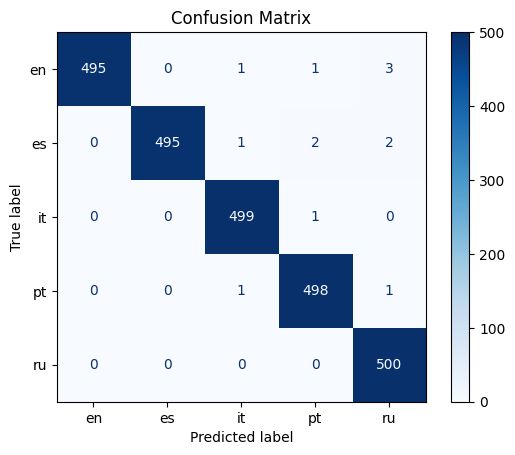

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = clf.predict(X_val)
cm = confusion_matrix(y_val_enc, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()



From this confusion matrix we can see our model performance in more detail. First thing that stands out is the 100% accuracy on russian. Meaning that 500 out of 500 russian reviews have been predicted russian. When filtering the languages you would expect that the errors would have been mainly in between the three roman languages, spanish, italian and portuguese. That is not exactly the case. Yes there are some mistakes made between them, but they also make mistakes by predicting russian. For example, if we look at portuguese, it predicted 498/500 portuguese reviews as portuguese, but was mistaken once for italian and once for russian.

There can be many reason for missclassifications. Perhaps, most of the words in the sentence were unknown to the classifier? Maybe english language is used in russian reviews during training? We can find the sentences that have been missclassified, to attempt to understand why they have been missclassified.

Tokens and unknown word count statistics for each sentence

In [29]:
import pandas as pd
import numpy as np

# Show full text in DataFrames
pd.set_option('display.max_colwidth', None)

# Ensure reviews are strings
reviews_val = [str(r) for r in reviews_val]

# Find wrong predictions
wrong_mask = y_val_enc != y_pred
wrong_indices = np.where(wrong_mask)[0]

# Build DataFrame
wrong_df = pd.DataFrame({
    "Index": wrong_indices,
    "True": [le.classes_[y_val_enc[i]] for i in wrong_indices],
    "Predicted": [le.classes_[y_pred[i]] for i in wrong_indices],
    "Tokens": [len(tokenizer(reviews_val[i])) for i in wrong_indices],
    "UNK count": [tokenizer(reviews_val[i]).count(0) for i in wrong_indices],
})

# Calculate UNK percentage
wrong_df["UNK %"] = (wrong_df["UNK count"] / wrong_df["Tokens"] * 100).round(2)

# Print nicely
print(wrong_df.to_string(index=False))


 Index True Predicted  Tokens  UNK count  UNK %
   524   es        pt       4          0   0.00
   530   en        it       5          0   0.00
   596   en        pt       5          1  20.00
   601   it        pt      10          3  30.00
   695   es        it       4          1  25.00
   817   en        ru       5          1  20.00
   852   es        ru      13          1   7.69
  1221   es        ru       6          1  16.67
  1303   pt        ru       4          2  50.00
  1617   en        ru      11          1   9.09
  1710   es        pt       8          1  12.50
  2098   en        ru       4          1  25.00
  2497   pt        it       9          3  33.33


Full sentences

In [30]:
import numpy as np

# Create mask for wrong predictions
wrong_mask = y_val_enc != y_pred
wrong_indices = np.where(wrong_mask)[0]

# Loop over wrong predictions for clean left-aligned print
for i in wrong_indices:
    tokens = tokenizer(reviews_val[i])
    unk_count = tokens.count(0)
    total_tokens = len(tokens)
    unk_percent = (unk_count / total_tokens * 100) if total_tokens > 0 else 0
    
    print(f"Index: {i}")
    print(f"True: {le.classes_[y_val_enc[i]]}")
    print(f"Predicted: {le.classes_[y_pred[i]]}")
    print(f"UNK count: {unk_count}/{total_tokens} ({unk_percent:.1f}%)")
    print(f"Text: {reviews_val[i]}")
    print("-" * 80)


Index: 524
True: es
Predicted: pt
UNK count: 0/4 (0.0%)
Text: Llego antes de tiempo
--------------------------------------------------------------------------------
Index: 530
True: en
Predicted: it
UNK count: 0/5 (0.0%)
Text: Mother in law loved them
--------------------------------------------------------------------------------
Index: 596
True: en
Predicted: pt
UNK count: 1/5 (20.0%)
Text: Geared more towards sight reading
--------------------------------------------------------------------------------
Index: 601
True: it
Predicted: pt
UNK count: 3/10 (30.0%)
Text: Sly Stallone's Sone Sage trovato morto a Los Angeles
--------------------------------------------------------------------------------
Index: 695
True: es
Predicted: it
UNK count: 1/4 (25.0%)
Text: Desempeña su función correctamente
--------------------------------------------------------------------------------
Index: 817
True: en
Predicted: ru
UNK count: 1/5 (20.0%)
Text: Makes your pee orange.
--------------------------

When looking at the missclassifications, it seems that most sentences have a low rate of unknown words. Meaning, that the errors made are likely due to the some data containing more than 1 language in a text. In other words, russian reviews using english, italian, spanish or portuguese words sometimes in their review. Another reason of missclassification is because some words are common in multiple languages. Words like "In" (English, Italian), "de" (Spanish, Portuguese), "a" (english, spanish, italian, portuguese) can all be reasons why the classifier is more leaning to a language than a another.

# Conclusion
In this tutorial we covered the key steps to create a basic text classifier:
- **Collecting Data**: We downloaded the Language Identification dataset by papluca [[8]](#8-papluca-language-identification-dataset-hugging-face-httpshuggingfacecodatasetspaplucalanguage-identification).
- **Data Preperation**: We filtered the dataset to 5 languages, tokenized our input, represented our data as bag-of-words and encoded our labels.
- **Modelling**: trained a language classifier.
- **Evaluation**: evaluated our model's performance.

If you want to dive deeper into text classification, I highly recommend reading Chapter 14 of *Deep Learning with Python* by François Chollet [[1]](#1-francois-chollet-deep-learning-with-python-third-edition-chapter-14-text-classification-httpsdeeplearningwithpythoniochapterschapter14_text-classification). This tutorial was mostly inspired by that chapter, which provides a strong foundation in text classification.

Once you feel comfortable with set-based models, you can move on to sequence-based models. The big difference between set- and sequence-based models is that sequence-based models **do** take word order into account. Together, set-based and sequence-based models form the foundation of most text classification methods, so understanding both of these is the most logical first step.



# Sources
- ##### [1] Francois Chollet. *Deep Learning with Python*, Third Edition, Chapter 14: Text Classification. https://deeplearningwithpython.io/chapters/chapter14_text-classification/
- ##### [2] pandas developers. *Getting started (pandas 2.3.3 documentation)*. https://pandas.pydata.org/pandas-docs/version/2.3.3/getting_started/index.html 
- ##### [3] fsspec developers. *fsspec documentation (latest)*. https://filesystem-spec.readthedocs.io/en/latest/
- ##### [4] Hugging Face developers. *huggingface_hub documentation (latest)*. https://huggingface.co/docs/huggingface_hub/
- ##### [5] scikit-learn developers. *scikit-learn 1.7.2 documentation*. https://scikit-learn.org/1.7/
- ##### [6] Matplotlib developers. *Matplotlib 3.10.8 documentation*. https://matplotlib.org/3.10.8/
- ##### [7] Seaborn developers. *Seaborn documentation*. https://seaborn.pydata.org/
- ##### [8] papluca. *Language Identification dataset*. Hugging Face. https://huggingface.co/datasets/papluca/language-identification


